In [ ]:
import pandas as pd 
import numpy as np
import sys
import os
import sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import nltk
import warnings
warnings.filterwarnings('ignore')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix

In [50]:
df = pd.read_csv("fake reviews dataset.csv")

In [51]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [52]:
df.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [53]:
missing_values = df.isnull().sum()
missing_values

category    0
rating      0
label       0
text_       0
dtype: int64

In [54]:
df.shape

(40432, 4)

In [ ]:
print("Rozkład etykiet:")
print(df['label'].value_counts())
print(f"\nProcent fake reviews: {(df['label'] == 'CG').mean()*100:.2f}%")
print(f"Procent real reviews: {(df['label'] == 'OR').mean()*100:.2f}%")

# Analiza kategorii
print("\nRozkład kategorii:")
print(df['category'].value_counts())

# Analiza ratingów w zależności od etykiety
print("\nŚredni rating dla fake vs real reviews:")
rating_by_label = df.groupby('label')['rating'].agg(['mean', 'std', 'count'])
print(rating_by_label)

Rozkład etykiet:
label
CG    20216
OR    20216
Name: count, dtype: int64

Procent fake reviews: 50.00%
Procent real reviews: 50.00%

Rozkład kategorii:
category
Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: count, dtype: int64

Średni rating dla fake vs real reviews:
           mean       std  count
label                           
CG     4.259893  1.141065  20216
OR     4.253265  1.147652  20216


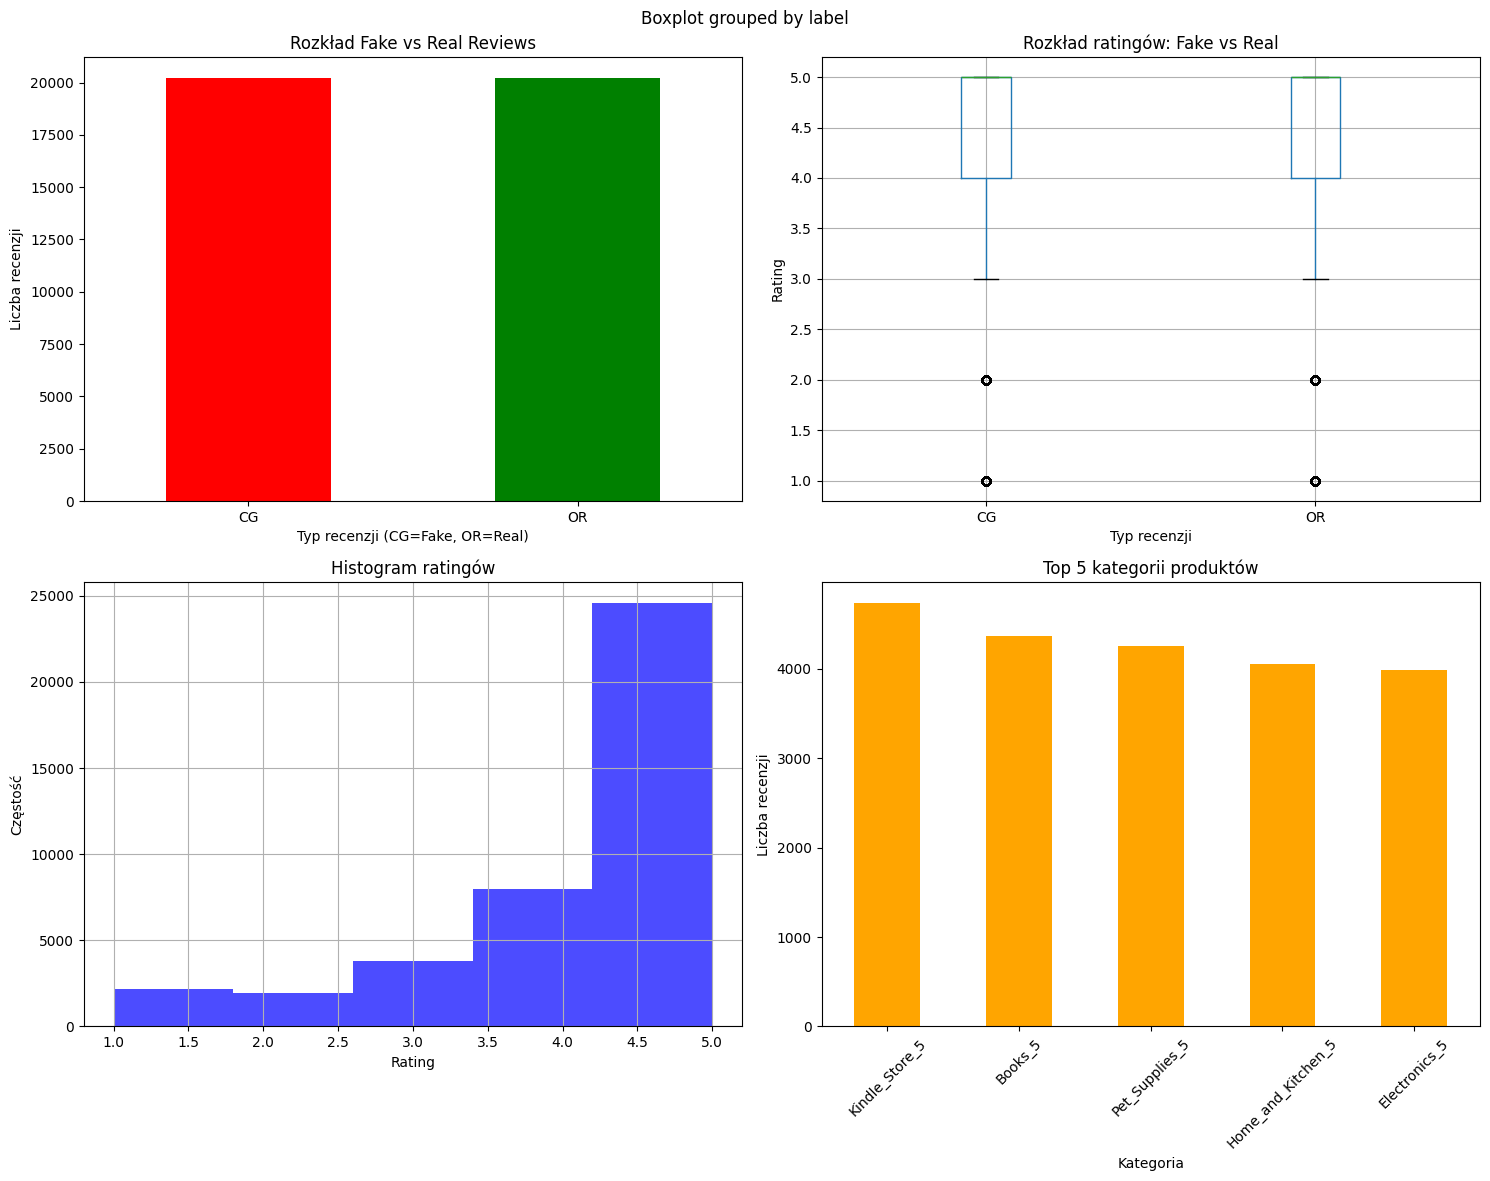

In [56]:
# Wizualizacje
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Rozkład etykiet
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['red', 'green'])
axes[0,0].set_title('Rozkład Fake vs Real Reviews')
axes[0,0].set_xlabel('Typ recenzji (CG=Fake, OR=Real)')
axes[0,0].set_ylabel('Liczba recenzji')
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Rozkład ratingów dla fake vs real
df.boxplot(column='rating', by='label', ax=axes[0,1])
axes[0,1].set_title('Rozkład ratingów: Fake vs Real')
axes[0,1].set_xlabel('Typ recenzji')
axes[0,1].set_ylabel('Rating')

# 3. Histogram ratingów
df['rating'].hist(bins=5, ax=axes[1,0], alpha=0.7, color='blue')
axes[1,0].set_title('Histogram ratingów')
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Częstość')

# 4. Top 5 kategorii
top_categories = df['category'].value_counts().head()
top_categories.plot(kind='bar', ax=axes[1,1], color='orange')
axes[1,1].set_title('Top 5 kategorii produktów')
axes[1,1].set_xlabel('Kategoria')
axes[1,1].set_ylabel('Liczba recenzji')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [57]:
# Funkcje do analizy tekstu
def count_words(text):
    return len(text.split())

def count_chars(text):
    return len(text)

def count_sentences(text):
    return len(re.findall(r'[.!?]+', text))

def count_exclamations(text):
    return text.count('!')

def count_capitals(text):
    return sum(1 for c in text if c.isupper())

def avg_word_length(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words) if words else 0

# Dodawanie cech tekstowych
df['word_count'] = df['text_'].apply(count_words)
df['char_count'] = df['text_'].apply(count_chars)
df['sentence_count'] = df['text_'].apply(count_sentences)
df['exclamation_count'] = df['text_'].apply(count_exclamations)
df['capital_count'] = df['text_'].apply(count_capitals)
df['avg_word_length'] = df['text_'].apply(avg_word_length)

print("Statystyki tekstowe dla fake vs real reviews:")
text_features = ['word_count', 'char_count', 'sentence_count', 'exclamation_count', 'capital_count', 'avg_word_length']

for feature in text_features:
    print(f"\n{feature}:")
    stats = df.groupby('label')[feature].agg(['mean', 'std'])
    print(stats)

Statystyki tekstowe dla fake vs real reviews:

word_count:
            mean        std
label                      
CG     61.288237  61.799015
OR     73.642610  76.078420

char_count:
             mean         std
label                        
CG     305.573506  307.037430
OR     396.970419  418.428047

sentence_count:
           mean       std
label                    
CG     5.354274  5.891200
OR     5.212307  4.799202

exclamation_count:
           mean       std
label                    
CG     0.275574  1.248413
OR     0.519490  1.515397

capital_count:
            mean        std
label                      
CG      8.552879  12.784899
OR     11.012268  18.281127

avg_word_length:
           mean       std
label                    
CG     4.046509  0.864254
OR     4.358762  0.505768


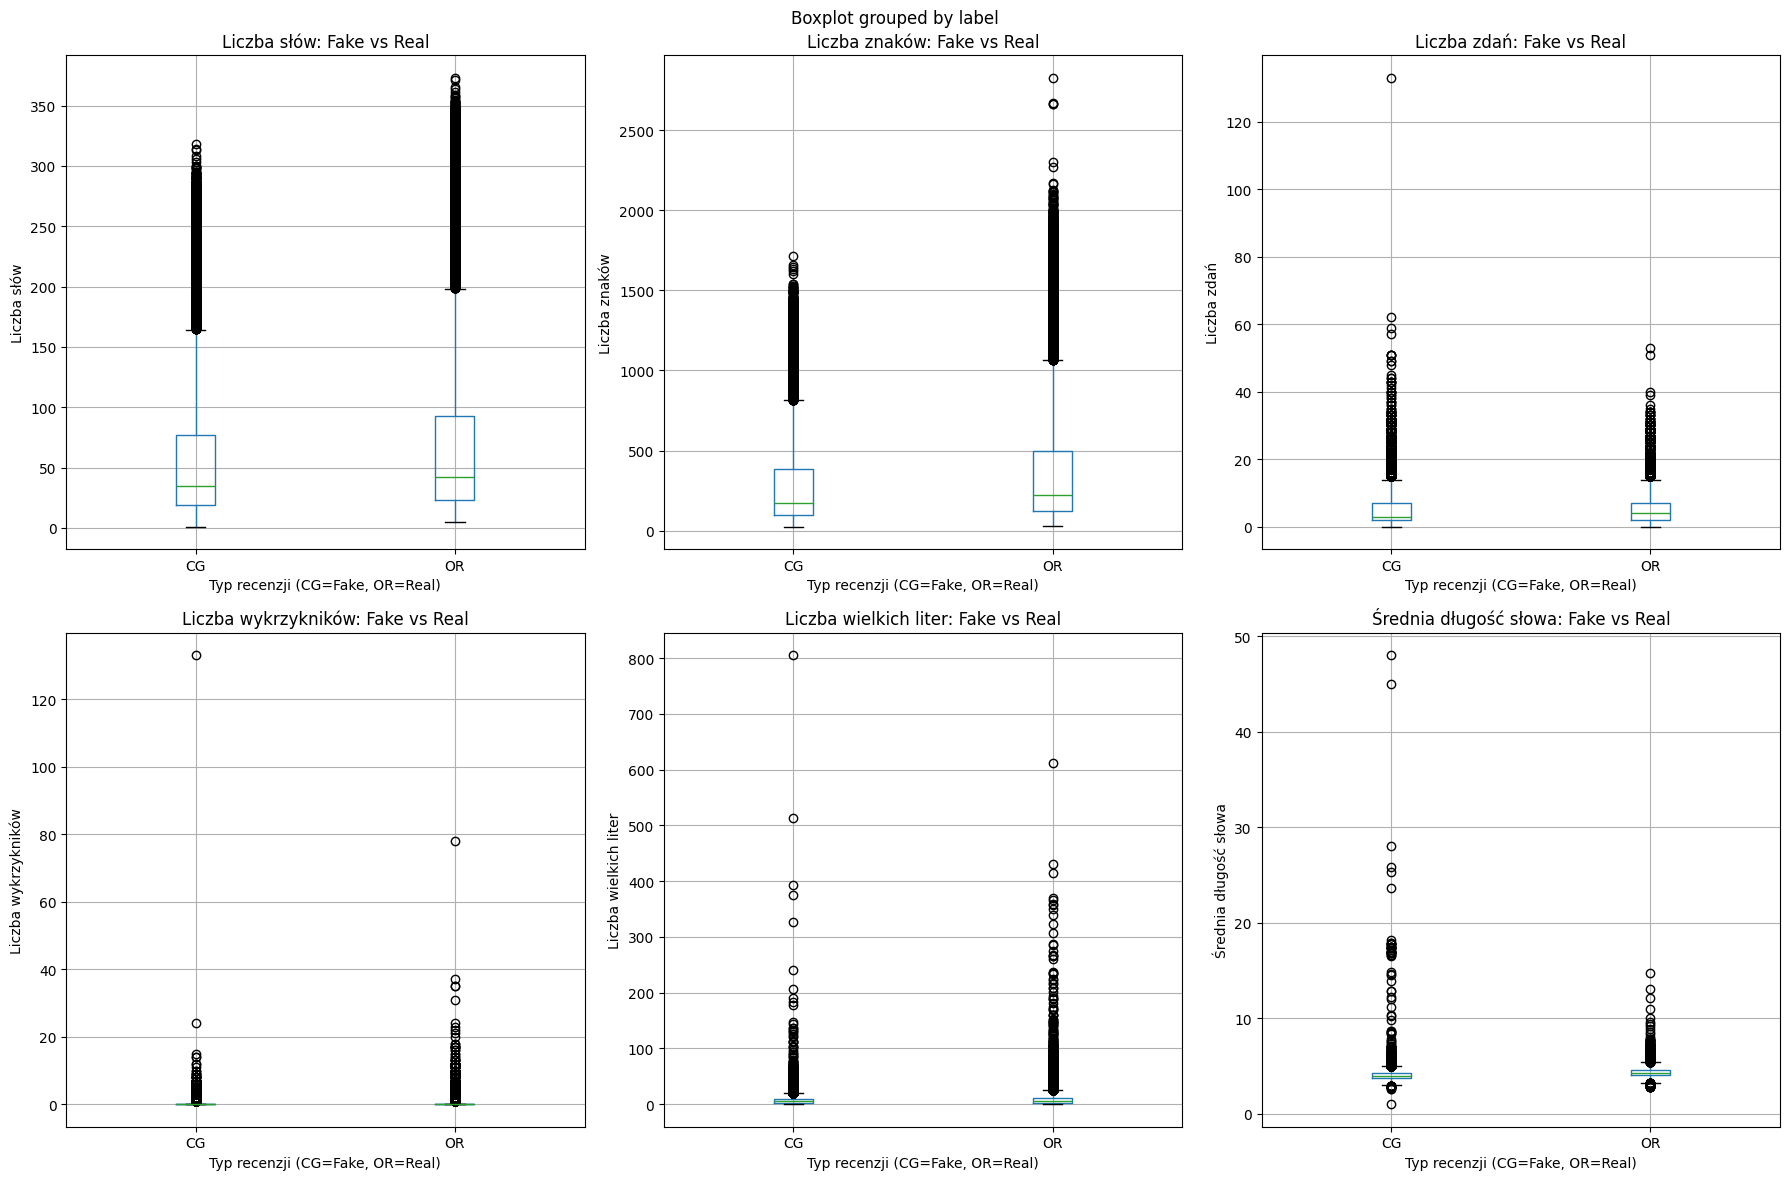

\nMatryca korelacji cech tekstowych:


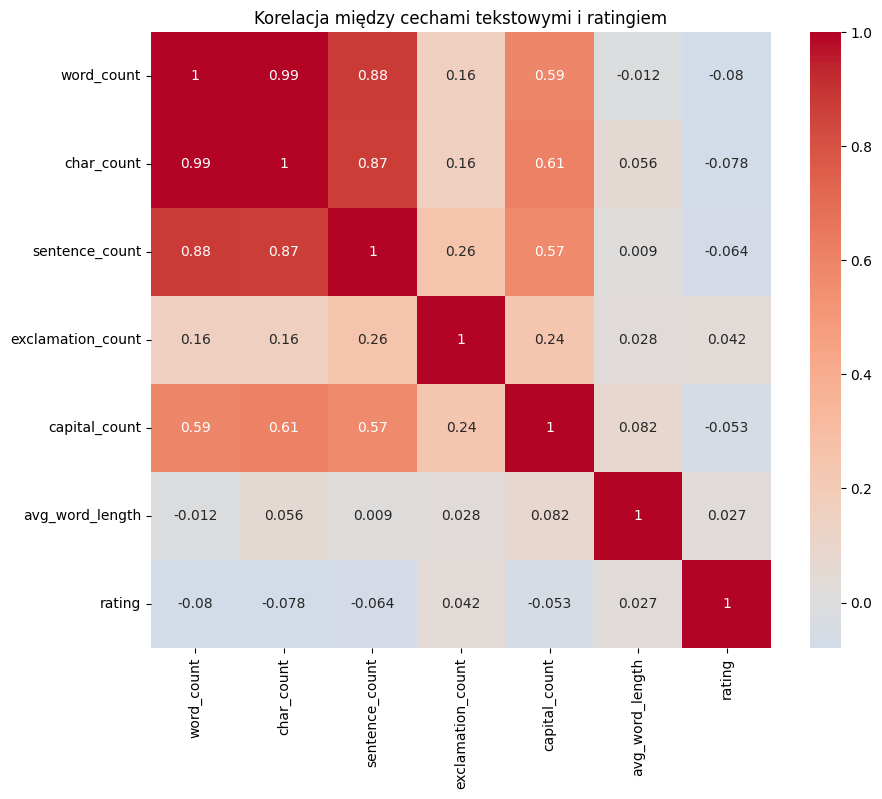

In [58]:
# Wizualizacja różnic tekstowych
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

text_features = ['word_count', 'char_count', 'sentence_count', 'exclamation_count', 'capital_count', 'avg_word_length']
titles = ['Liczba słów', 'Liczba znaków', 'Liczba zdań', 'Liczba wykrzykników', 'Liczba wielkich liter', 'Średnia długość słowa']

for i, (feature, title) in enumerate(zip(text_features, titles)):
    df.boxplot(column=feature, by='label', ax=axes[i])
    axes[i].set_title(f'{title}: Fake vs Real')
    axes[i].set_xlabel('Typ recenzji (CG=Fake, OR=Real)')
    axes[i].set_ylabel(title)

plt.tight_layout()
plt.show()

# Korelacja między cechami
print("\\nMatryca korelacji cech tekstowych:")
correlation_matrix = df[text_features + ['rating']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Korelacja między cechami tekstowymi i ratingiem')
plt.show()

In [ ]:
# Funkcja do czyszczenia tekstu
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Czyszczenie tekstu
df['cleaned_text'] = df['text_'].apply(clean_text)

# Przygotowanie cech

# 1. Cechy tekstowe 
text_features = ['word_count', 'char_count', 'sentence_count', 'exclamation_count', 'capital_count', 'avg_word_length']

# 2. Rating jako cecha
numerical_features = text_features + ['rating']

# 3. Kategoria jako cecha (one-hot encoding)
category_dummies = pd.get_dummies(df['category'], prefix='category')

# Połączenie wszystkich cech numerycznych
X_numerical = pd.concat([df[numerical_features], category_dummies], axis=1)

# Etykiety (0 = Real, 1 = Fake)
y = (df['label'] == 'CG').astype(int)

print(f"Kształt danych numerycznych: {X_numerical.shape}")
print(f"Rozkład etykiet: {y.value_counts().to_dict()}")

# Podział danych
X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_numerical, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Rozmiar zbioru treningowego: {X_train_num.shape}")
print(f"Rozmiar zbioru testowego: {X_test_num.shape}")

# Podział tekstów
X_train_text = df.loc[X_train_num.index, 'cleaned_text']
X_test_text = df.loc[X_test_num.index, 'cleaned_text']

Kształt danych numerycznych: (40432, 17)
Rozkład etykiet: {1: 20216, 0: 20216}
Rozmiar zbioru treningowego: (32345, 17)
Rozmiar zbioru testowego: (8087, 17)


In [ ]:
# Model 1 Tylko cechy numeryczne + Random Forest
print("\\n=== MODEL 1: Random Forest z cechami numerycznymi ===")

rf_num = RandomForestClassifier(n_estimators=100, random_state=42)
rf_num.fit(X_train_num, y_train)
y_pred_rf_num = rf_num.predict(X_test_num)

print("Classification Report:")
print(classification_report(y_test, y_pred_rf_num))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_num.predict_proba(X_test_num)[:, 1]):.4f}")

# Ważność cech
feature_importance = pd.DataFrame({
    'feature': X_numerical.columns,
    'importance': rf_num.feature_importances_
}).sort_values('importance', ascending=False)

print("\\nNajważniejsze cechy:")
print(feature_importance.head(10))

# Model 2 TF-IDF + Logistic Regression
print("\\n=== MODEL 2: TF-IDF + Logistic Regression ===")

# Pipeline z TF-IDF i regresją logistyczną
tfidf_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))),
    ('scaler', StandardScaler(with_mean=False)), 
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

tfidf_lr.fit(X_train_text, y_train)
y_pred_tfidf_lr = tfidf_lr.predict(X_test_text)

print("Classification Report:")
print(classification_report(y_test, y_pred_tfidf_lr))
print(f"ROC AUC Score: {roc_auc_score(y_test, tfidf_lr.predict_proba(X_test_text)[:, 1]):.4f}")

# Model 3: Naive Bayes z CountVectorizer
print("\\n=== MODEL 3: Naive Bayes + Count Vectorizer ===")

count_nb = Pipeline([
    ('count', CountVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))),
    ('nb', MultinomialNB())
])

count_nb.fit(X_train_text, y_train)
y_pred_count_nb = count_nb.predict(X_test_text)

print("Classification Report:")
print(classification_report(y_test, y_pred_count_nb))
print(f"ROC AUC Score: {roc_auc_score(y_test, count_nb.predict_proba(X_test_text)[:, 1]):.4f}")

\n=== MODEL 1: Random Forest z cechami numerycznymi ===
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      4044
           1       0.76      0.76      0.76      4043

    accuracy                           0.76      8087
   macro avg       0.76      0.76      0.76      8087
weighted avg       0.76      0.76      0.76      8087

ROC AUC Score: 0.8435
\nNajważniejsze cechy:
                     feature  importance
5            avg_word_length    0.297112
1                 char_count    0.185461
0                 word_count    0.140116
4              capital_count    0.106203
2             sentence_count    0.105264
6                     rating    0.042952
3          exclamation_count    0.025082
7           category_Books_5    0.010905
11   category_Kindle_Store_5    0.010613
12  category_Movies_and_TV_5    0.010010
\n=== MODEL 2: TF-IDF + Logistic Regression ===
Classification Report:
              precision    

In [ ]:
# Model 4 Hybrydowy model (tekst + cechy numeryczne)
print("\\n=== MODEL 4: Hybrydowy model (tekst + cechy numeryczne) ===")
class HybridFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, tfidf_max_features=5000):
        self.tfidf = TfidfVectorizer(max_features=tfidf_max_features, 
                                   stop_words='english', 
                                   ngram_range=(1, 2))
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        # X to tuple (text_data, numerical_data)
        text_data, numerical_data = X
        self.tfidf.fit(text_data)
        self.scaler.fit(numerical_data)
        return self
        
    def transform(self, X):
        text_data, numerical_data = X
        text_features = self.tfidf.transform(text_data)
        numerical_features = self.scaler.transform(numerical_data)
        
        
        numerical_sparse = csr_matrix(numerical_features)
        combined_features = hstack([text_features, numerical_sparse])
        
        return combined_features

# Przygotowanie danych hybrydowych
X_train_hybrid = (X_train_text, X_train_num)
X_test_hybrid = (X_test_text, X_test_num)

# Pipeline hybrydowy
hybrid_pipeline = Pipeline([
    ('features', HybridFeatures(tfidf_max_features=3000)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Trenowanie modelu
hybrid_pipeline.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_pipeline.predict(X_test_hybrid)

print("Classification Report:")
print(classification_report(y_test, y_pred_hybrid))
print(f"ROC AUC Score: {roc_auc_score(y_test, hybrid_pipeline.predict_proba(X_test_hybrid)[:, 1]):.4f}")

# Model 5 Gradient Boosting z cechami numerycznymi
print("\\n=== MODEL 5: Gradient Boosting z cechami numerycznymi ===")

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_num, y_train)
y_pred_gb = gb_model.predict(X_test_num)

print("Classification Report:")
print(classification_report(y_test, y_pred_gb))
print(f"ROC AUC Score: {roc_auc_score(y_test, gb_model.predict_proba(X_test_num)[:, 1]):.4f}")

# Porównanie wszystkich modeli
print("\\n=== PODSUMOWANIE WYNIKÓW ===")
results = {
    'Random Forest (numerical)': roc_auc_score(y_test, rf_num.predict_proba(X_test_num)[:, 1]),
    'TF-IDF + Logistic Regression': roc_auc_score(y_test, tfidf_lr.predict_proba(X_test_text)[:, 1]),
    'Count Vectorizer + Naive Bayes': roc_auc_score(y_test, count_nb.predict_proba(X_test_text)[:, 1]),
    'Hybrid Model': roc_auc_score(y_test, hybrid_pipeline.predict_proba(X_test_hybrid)[:, 1]),
    'Gradient Boosting (numerical)': roc_auc_score(y_test, gb_model.predict_proba(X_test_num)[:, 1])
}

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'ROC AUC'])
results_df = results_df.sort_values('ROC AUC', ascending=False)
print(results_df)

\n=== MODEL 4: Hybrydowy model (tekst + cechy numeryczne) ===
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      4044
           1       0.90      0.89      0.90      4043

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087

ROC AUC Score: 0.9597
\n=== MODEL 5: Gradient Boosting z cechami numerycznymi ===
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      4044
           1       0.90      0.89      0.90      4043

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087

ROC AUC Score: 0.9597
\n=== MODEL 5: Gradient Boosting z cechami numerycznymi ===
Classification Report:
              precision    recall  f1-score   suppo

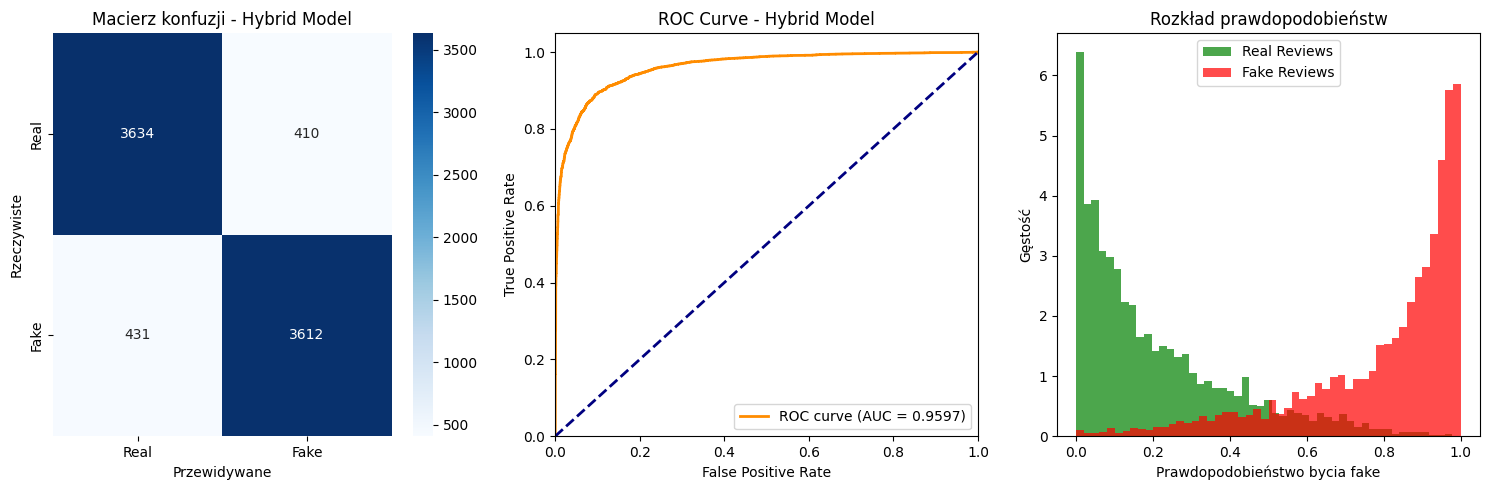

In [ ]:

# Macierz konfuzji
plt.figure(figsize=(15, 5))

# 1. Macierz konfuzji
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_hybrid)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Macierz konfuzji - Hybrid Model')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')

# 2. ROC Curve
plt.subplot(1, 3, 2)
y_proba = hybrid_pipeline.predict_proba(X_test_hybrid)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Hybrid Model')
plt.legend(loc="lower right")

# 3. Rozkład prawdopodobieństw
plt.subplot(1, 3, 3)
fake_proba = y_proba[y_test == 1]
real_proba = y_proba[y_test == 0]

plt.hist(real_proba, bins=50, alpha=0.7, label='Real Reviews', color='green', density=True)
plt.hist(fake_proba, bins=50, alpha=0.7, label='Fake Reviews', color='red', density=True)
plt.xlabel('Prawdopodobieństwo bycia fake')
plt.ylabel('Gęstość')
plt.title('Rozkład prawdopodobieństw')
plt.legend()

plt.tight_layout()
plt.show()

Text(1066.1767676767674, 0.5, 'Metryki')

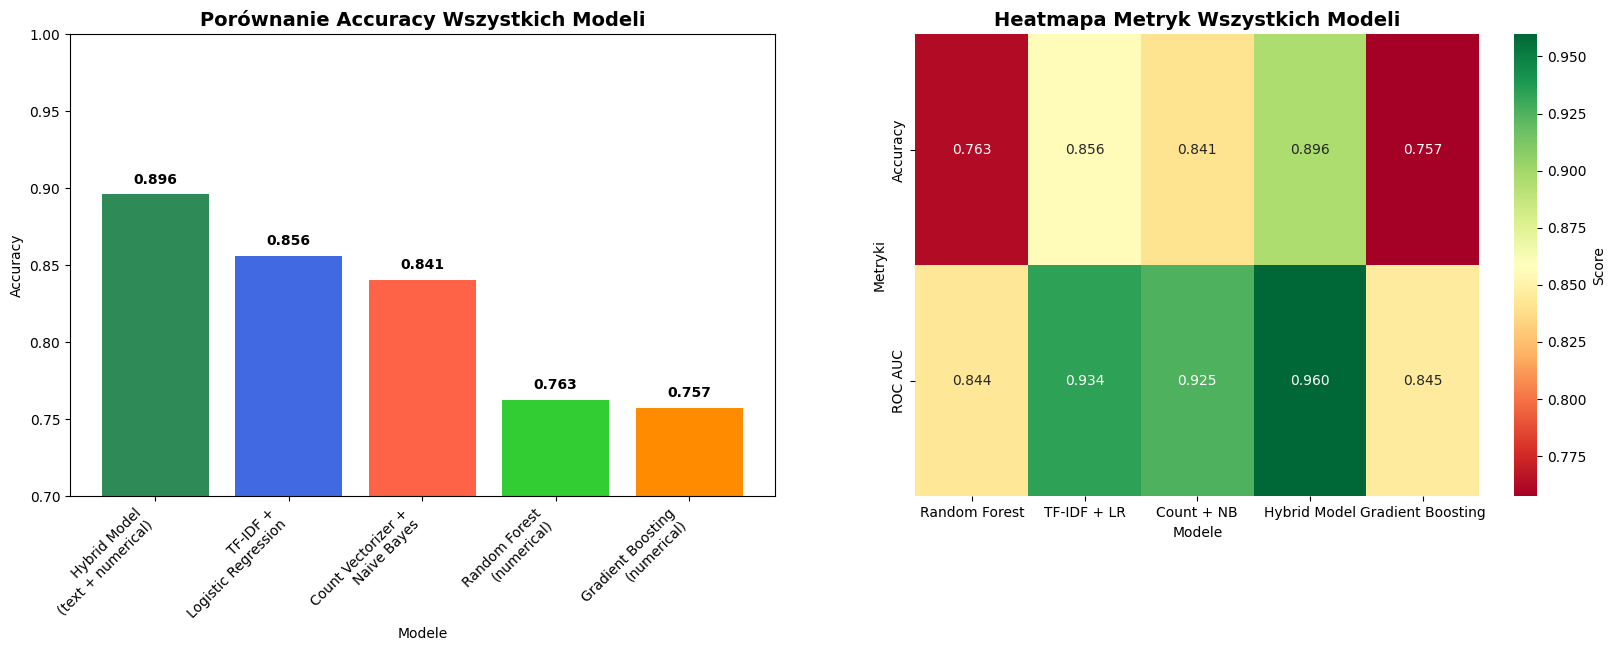

In [ ]:
# accuracy
accuracy_scores = {
    'Random Forest\n(numerical)': accuracy_score(y_test, y_pred_rf_num),
    'TF-IDF +\nLogistic Regression': accuracy_score(y_test, y_pred_tfidf_lr),
    'Count Vectorizer +\nNaive Bayes': accuracy_score(y_test, y_pred_count_nb),
    'Hybrid Model\n(text + numerical)': accuracy_score(y_test, y_pred_hybrid),
    'Gradient Boosting\n(numerical)': accuracy_score(y_test, y_pred_gb)
}

accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Model', 'Accuracy'])
accuracy_df = accuracy_df.sort_values('Accuracy', ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# 1. Wykres słupkowy accuracy
bars = axes[0].bar(range(len(accuracy_df)), accuracy_df['Accuracy'], 
                   color=['#2E8B57', '#4169E1', '#FF6347', '#32CD32', '#FF8C00'])
axes[0].set_title('Porównanie Accuracy Wszystkich Modeli', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Modele')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(len(accuracy_df)))
axes[0].set_xticklabels(accuracy_df['Model'], rotation=45, ha='right')
axes[0].set_ylim(0.7, 1.0)

for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Heatmapa porównująca metryki
metrics_data = {
    'Model': ['Random Forest', 'TF-IDF + LR', 'Count + NB', 'Hybrid Model', 'Gradient Boosting'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf_num),
                accuracy_score(y_test, y_pred_tfidf_lr),
                accuracy_score(y_test, y_pred_count_nb),
                accuracy_score(y_test, y_pred_hybrid),
                accuracy_score(y_test, y_pred_gb)],
    'ROC AUC': [roc_auc_score(y_test, rf_num.predict_proba(X_test_num)[:, 1]),
               roc_auc_score(y_test, tfidf_lr.predict_proba(X_test_text)[:, 1]),
               roc_auc_score(y_test, count_nb.predict_proba(X_test_text)[:, 1]),
               roc_auc_score(y_test, hybrid_pipeline.predict_proba(X_test_hybrid)[:, 1]),
               roc_auc_score(y_test, gb_model.predict_proba(X_test_num)[:, 1])]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_matrix = metrics_df[['Accuracy', 'ROC AUC']].T

sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=metrics_df['Model'], ax=axes[1], 
            cbar_kws={'label': 'Score'})
axes[1].set_title('Heatmapa Metryk Wszystkich Modeli', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Modele')
axes[1].set_ylabel('Metryki')




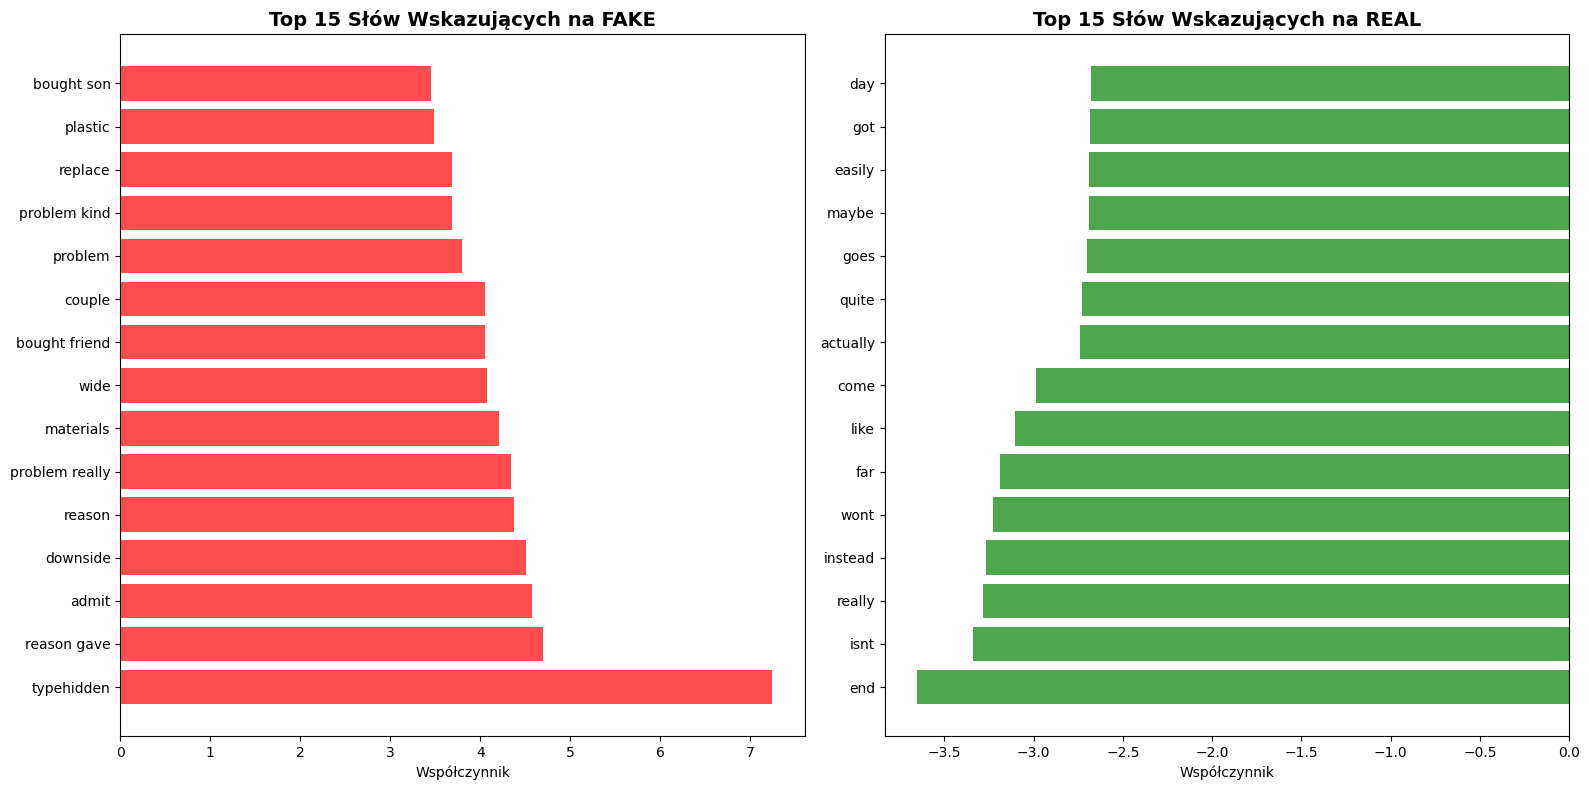

In [ ]:
# Analiza najważniejszych słów dla najlepszego modelu (Hybrid Model)
lr_classifier = hybrid_pipeline.named_steps['classifier']
feature_transformer = hybrid_pipeline.named_steps['features']

# Analiza współczynników
coefficients = lr_classifier.coef_[0]
n_text_features = len(feature_transformer.tfidf.get_feature_names_out())

# Analiza cech tekstowych (słowa)
text_coefs = coefficients[:n_text_features]
vocabulary = feature_transformer.tfidf.get_feature_names_out()

text_features_importance = pd.DataFrame({
    'Słowo/N-gram': vocabulary,
    'Współczynnik': text_coefs,
    'Abs_Współczynnik': np.abs(text_coefs),
    'Kierunek': ['FAKE' if c > 0 else 'REAL' for c in text_coefs]
}).sort_values('Abs_Współczynnik', ascending=False)

# Wizualizacja najważniejszych słów FAKE vs REAL
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top słowa dla FAKE
top_fake_words = text_features_importance[text_features_importance['Kierunek'] == 'FAKE'].head(15)
bars1 = axes[0].barh(range(len(top_fake_words)), top_fake_words['Współczynnik'], color='red', alpha=0.7)
axes[0].set_yticks(range(len(top_fake_words)))
axes[0].set_yticklabels(top_fake_words['Słowo/N-gram'])
axes[0].set_xlabel('Współczynnik')
axes[0].set_title('Top 15 Słów Wskazujących na FAKE', fontsize=14, fontweight='bold')

# Top słowa dla REAL
top_real_words = text_features_importance[text_features_importance['Kierunek'] == 'REAL'].head(15)
bars2 = axes[1].barh(range(len(top_real_words)), top_real_words['Współczynnik'], color='green', alpha=0.7)
axes[1].set_yticks(range(len(top_real_words)))
axes[1].set_yticklabels(top_real_words['Słowo/N-gram'])
axes[1].set_xlabel('Współczynnik')
axes[1].set_title('Top 15 Słów Wskazujących na REAL', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()